# Experimento 1 - Atualizado
***
- Conjuntos de dados: Montgomery
- Aplicando mudança de escala típica nas imagens

### Importando os pacotes necessários

In [1]:
import glob
import re
from tqdm import tqdm
import urllib.request
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

### Pré-processando os dados

In [3]:
# coletando o caminho dos arquivos dos dados do hospital montgomery
filelist_montgomery = glob.glob('/content/drive/MyDrive/Montgomery/MontgomerySet/CXR_png/*.png')

In [4]:
# quantidade de imagens disponíveis no dataset
print('quantidade de imagens:', str(len(filelist_montgomery)))

quantidade de imagens: 138


In [26]:
def extract_label(file_list):
    
    # inicializando uma lista vazia
    labels = []
    
    # iterando na lista de arquivos
    for file in tqdm(file_list):
        # detectando as classes presentes no nome da imagem
        current_label = re.findall('[0-9]{4}_(.+?).png', file)
        # adicionando a lista de rótulos as classes correspondentes a cada uma das imagens
        if current_label[0] == '0':
          labels.append('normal')
        else:
          labels.append('abnormal')
        
    return labels

In [27]:
# extraindo os rótulos
labels = extract_label(filelist_montgomery)

100%|██████████| 138/138 [00:00<00:00, 35738.08it/s]


In [28]:
# visualizando a quantidade de rótulos
print('quantidade de rótulos:', str(len(labels)))

quantidade de rótulos: 138


In [29]:
# criando um dataframe com os caminhos das imagens
full_data = pd.DataFrame(filelist_montgomery, columns = ['filepath'])
# adicionando os rótulos em cada imagem
full_data['target'] = labels

In [30]:
# separando os dados de treinamento e de teste
train_df, test_df = train_test_split(full_data, stratify = full_data['target'],
                                     test_size = 0.2, random_state = 42)

In [31]:
# separando os dados de validação dos dados de treinamento
train_df, validation_df = train_test_split(train_df, stratify = train_df['target'],
                                           test_size = 0.2, random_state = 42)

In [32]:
# visualizando a quantidade de dados
print('quantidade de imagens de treinamento:', len(train_df['filepath']))
print('quantidade de rótulos de treinamento:', len(train_df['target']))
print('quantidade de imagens de teste:', len(test_df['filepath']))
print('quantidade de rótulos de teste:', len(test_df['target']))
print('quantidade de imagens de validação:', len(validation_df['filepath']))
print('quantidade de rótulos de validação:', len(validation_df['target']))

quantidade de imagens de treinamento: 88
quantidade de rótulos de treinamento: 88
quantidade de imagens de teste: 28
quantidade de rótulos de teste: 28
quantidade de imagens de validação: 22
quantidade de rótulos de validação: 22


In [34]:
# observando a distribuição na quantidade de dados disponíveis
train_df['target'].value_counts()
# fazendo um balanceamento nos pesos das classes
class_weight = {0: (51+37)/51, 1: (51+37)/37}

### Aplicando mudança de escala típica

In [37]:
# normalizando as imagens de treinamento e aplicando aumento de dados
image_generator = ImageDataGenerator(rescale = 1./255., rotation_range = 10, zoom_range = 0.2)

# criando o gerador de imagens de treinamento 
train_generator = image_generator.flow_from_dataframe(
                                                      dataframe = train_df,
                                                      directory = '',
                                                      x_col = 'filepath',
                                                      y_col = 'target',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'categorical',
                                                      target_size = (256, 256))

# normalizando as imagens de teste e validação
test_datagen = ImageDataGenerator(rescale = 1./255.)

# criando o gerador de imagens de validação 
valid_generator = test_datagen.flow_from_dataframe(
                                                      dataframe = validation_df,
                                                      directory = '.', 
                                                      x_col = 'filepath',
                                                      y_col = 'target',
                                                      batch_size = 22,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'categorical',
                                                      target_size = (256, 256))

test_generator = test_datagen.flow_from_dataframe(
                                                  dataframe = test_df, 
                                                  directory = '.',
                                                  x_col = 'filepath',
                                                  y_col = 'target',
                                                  batch_size = 28,
                                                  seed = 42,
                                                  shuffle = True,
                                                  class_mode = 'categorical',
                                                  target_size = (256, 256))

Found 88 validated image filenames belonging to 2 classes.
Found 22 validated image filenames belonging to 2 classes.
Found 28 validated image filenames belonging to 2 classes.


### Preparando a rede neural convolucional

In [ ]:
# baixando os pesos treinados da rede inception
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-03-02 21:39:42--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 142.250.73.240, 172.217.7.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   105MB/s    in 0.8s    

2021-03-02 21:39:43 (105 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# referenciando o local em que os pesos estão armazenados
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# carregando a arquitetura inception pré-treinada
pre_trained_model = InceptionV3(input_shape = (256, 256, 3), 
                                include_top = False, 
                                weights = None)

# carregando os pesos treinados com outros dados 
pre_trained_model.load_weights(local_weights_file)

# definindo as flags iniciais  
pre_trained_model.trainable = True
set_trainable = False

# para a arquitetura inception, a rede será retreinada a partir da camada 'mixed6'
for layer in pre_trained_model.layers:
    if layer.name == 'mixed6':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# obtendo a última camada como sendo a nomeada por 'mixed7'
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 127, 127, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 127, 127, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 127, 127, 32) 0           batch_normalization_376[0][0]    
_______________________________________________________________________________________

In [ ]:
# definindo uma camada de achatamento
x = layers.Flatten()(last_output)
# conecatando a rede uma camada com 1024 neurônios e função de ativação relu
x = layers.Dense(units = 1024, activation = tf.nn.relu)(x)     
# conecatando a rede uma camada com 128 neurônios e função de ativação relu
x = layers.Dense(units = 512, activation = tf.nn.relu)(x) 
# aplicando uma camada de dropout com uma taxa de 20% (normalização)
x = layers.Dropout(rate = 0.2)(x)                  
# adicionando uma camada de saída com um neurônio e uma função de ativação sigmoide
x = layers.Dense  (units = 2, activation = tf.nn.sotfmax)(x)           

# conecatando as camadas definidas acima com a arquitetura inception
model = Model(pre_trained_model.input, x) 

# compilando a rede 
model.compile(optimizer = optimizers.RMSprop(learning_rate = 0.0001), loss = 'categorical_crossentropy', 
              metrics = ['acc'], class_weight = class_weight) 

In [ ]:
# definindo o caminho pelo qual os pesos serão armazenados 
filepath = "transferlearning_weights.hdf5"
# callback para salvar o melhor valor dos pesos em relação ao desempenho com os dados de validação 
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

In [ ]:
# definindo um array de callbacks
callbacks = [checkpoint]

In [ ]:
# treinando a rede neural convolucional
history = model.fit_generator(train_generator, steps_per_epoch = 88 // 32, 
                              validation_data = valid_generator, validation_steps = 1
                              callbacks = callbacks, epochs = 100, use_multiprocessing = True)

Epoch 1/100
2/2 [==============================] - 33s 23s/step - loss: 0.8146 - acc: 0.4623 - val_loss: 8.9109 - val_acc: 0.4091

Epoch 00001: val_acc improved from -inf to 0.40909, saving model to transferlearning_weights.hdf5
Epoch 2/100
2/2 [==============================] - 22s 14s/step - loss: 6.6101 - acc: 0.4464 - val_loss: 1.2619 - val_acc: 0.4091

Epoch 00002: val_acc did not improve from 0.40909
Epoch 3/100
2/2 [==============================] - 24s 16s/step - loss: 1.6347 - acc: 0.4583 - val_loss: 0.7732 - val_acc: 0.5455

Epoch 00003: val_acc improved from 0.40909 to 0.54545, saving model to transferlearning_weights.hdf5
Epoch 4/100
2/2 [==============================] - 23s 16s/step - loss: 0.6397 - acc: 0.6746 - val_loss: 0.6381 - val_acc: 0.6818

Epoch 00004: val_acc improved from 0.54545 to 0.68182, saving model to transferlearning_weights.hdf5
Epoch 5/100
2/2 [==============================] - 24s 16s/step - loss: 0.4919 - acc: 0.6875 - val_loss: 0.5332 - val_acc: 0.7

### Salvando o modelo desenvolvido

In [ ]:
# carregando o melhor peso obtido para o modelo
best_model = model
best_model.load_weights('/content/transferlearning_weights.hdf5')

In [ ]:
# salvando os dois modelos obtidos durante o treinamento
model.save('model1')
best_model.save('model2')

INFO:tensorflow:Assets written to: model1/assets
INFO:tensorflow:Assets written to: model2/assets


In [ ]:
# carregando o melhor modelo para realização de testes de desempenho
model = tf.keras.models.load_model('/content/drive/MyDrive/experimentos/experimento1-dataset1-parte1/model2')

### Métricas de avaliação do modelo

In [ ]:
# carregando os dados de teste
(x, y) = test_generator[0]

In [ ]:
# realizando a predição para os dados de teste
predict = model.predict(x)

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

def thresholds(limiar, predict):
  '''predição para diferentes thresholds'''

  predict_ = []
  for i in predict:
    if i > limiar:
      predict_.append(1)
    else:
      predict_.append(0)
  
  return predict_

def precision_recall_accuracy_curve(predict, y):
  ''' Relaciona a curva da Precisão, Sensibilidade e Acurácia em relação a diferentes Thresholds'''

  limiares = np.arange(0, 1, 0.05)
  predicts = []
  precisions = []
  recalls = []
  accuracy = []
  flag = 0
  for i in limiares:
    predicts.append(thresholds(i, predict))
    precisions.append(precision_score(predicts[flag], y))
    recalls.append(recall_score(predicts[flag], y))
    accuracy.append(accuracy_score(predicts[flag], y))
    flag += 1
  
  return precisions, recalls, accuracy

def plot_precision_recall_accuracy_curve(precisions, recalls, accuracy):
  '''Plotando a curva de Precisão, Sensibilidade e Acurácia'''

  plt.figure(figsize = (10,5))
  plt.plot(np.arange(0, 1, 0.05), precisions, label = 'Precision')
  plt.plot(np.arange(0, 1, 0.05), recalls, label = 'Recall')
  plt.plot(np.arange(0, 1, 0.05), accuracy, label = 'Accuracy')
  plt.title('Precisão, Sensibilidade e Acurácia para diferentes Thresholds')
  plt.xlabel('Thresholds')
  plt.legend()
  plt.savefig('curve-analysis')

  return None

def best_metrics(threshold, predict, y):
  '''Melhores valores para o threshold escolhido'''

  predict_ = thresholds(threshold, predict)
  print('Matriz de Confusão:\n', confusion_matrix(predict_, y))
  print('Acurácia:', accuracy_score(predict_, y))
  print('Precisão', precision_score(predict_, y))
  print('Sensibilidade:', recall_score(predict_, y)) 
  print('F1_Score:', f1_score(predict_, y))

  return None

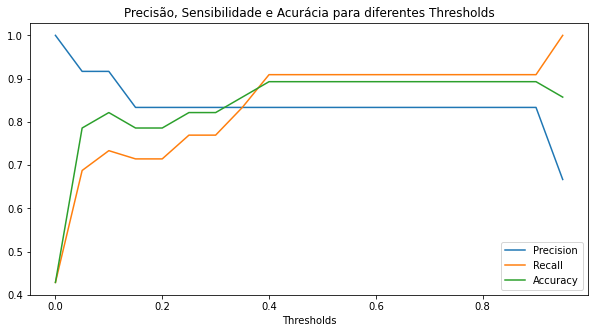

In [ ]:
# plotando a curva da Precisão, Sensibilidade e Acurácia 
precisions, recalls, accuracy = precision_recall_accuracy_curve(predict, y)
plot_precision_recall_accuracy_curve(precisions, recalls, accuracy)

In [ ]:
# analisando as melhores métricas encontradas para o modelo
best_metrics(threshold = 0.50, predict = predict, y = y)

Matriz de Confusão:
 [[15  2]
 [ 1 10]]
Acurácia: 0.8928571428571429
Precisão 0.8333333333333334
Sensibilidade: 0.9090909090909091
F1_Score: 0.8695652173913043


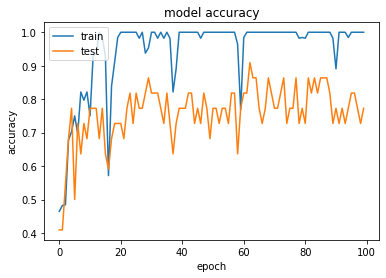

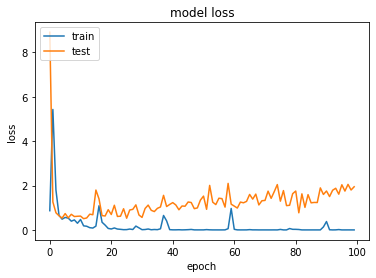

<Figure size 432x288 with 0 Axes>

In [ ]:
# plotando o histórico de treinamento
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model-accuracy')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model-loss')

In [ ]:
# visualizando a arquitetura do modelo
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 127, 127, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 127, 127, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 127, 127, 32) 0           batch_normalization_376[0][0]    
____________________________________________________________________________________________